In [40]:
# Round robin

import random
import pandas as pd
from itertools import combinations, chain

import matplotlib.pyplot as plt
import numpy as np


numtrials = 1000
totaltime = 0
total_games_played = 0

In [41]:
countries = [
    "Brazil",
    "Spain",
    "France",
    "Argentina",
    "Uruguay",
    "Colombia",
    "United Kingdom",
    "Paraguay",
    "Germany",
    "Ecuador",
    "Portugal",
    "Italy",
    "Morocco",
    "Egypt",
    "South Korea",
    "Japan",
    "Mexico",
    "Costa Rica",
    "New Zealand",
    "Australia",
]

elo_ratings = [
    1994,
    2150,
    2031,
    2140,
    1922,
    1953,
    2012,
    1799,
    1988,
    1911,
    1988,
    1914,
    1807,
    1668,
    1745,
    1875,
    1817,
    1653,
    1596,
    1736,
]

countriesratings = {country: elo_ratings[countries.index(country)] for country in countries}


In [42]:
import folium
from IPython.display import display

locations = [
    (-14.2350, -51.9253),  # Brazil
    (40.4637, -3.7492),    # Spain
    (46.6034, 1.8883),     # France
    (-38.4161, -63.6167),  # Argentina
    (-32.5228, -55.7659),  # Uruguay
    (4.5709, -74.2973),    # Colombia
    (55.3781, -3.4360),    # United Kingdom
    (-23.4420, -58.4438),  # Paraguay
    (51.1657, 10.4515),    # Germany
    (-1.8312, -78.1834),   # Ecuador
    (39.3999, -8.2245),    # Portugal
    (41.8719, 12.5674),    # Italy
    (31.7915, -7.0926),    # Morocco
    (26.8206, 30.8025),    # Egypt
    (35.9078, 127.7669),   # South Korea
    (36.2048, 138.2529),   # Japan
    (23.6345, -102.5528),  # Mexico
    (9.7489, -83.7534),    # Costa Rica
    (-40.9006, 174.8860),  # New Zealand
    (-25.2744, 133.7751),   # Australia
]

locationdict = {country: locations[countries.index(country)] for country in countries}
print(locationdict)

games_played_country = {country: 0 for country in countries}

# plot all countries on a map
m = folium.Map(location=[20, 20], zoom_start=2)
for name, rating, location in zip(countries, countriesratings.values(), locations):
    folium.Marker(
        location=location,
        icon=folium.Icon(color="red"),
        tooltip=f"{name} [{rating}]",
    ).add_to(m)
display(m)

{'Brazil': (-14.235, -51.9253), 'Spain': (40.4637, -3.7492), 'France': (46.6034, 1.8883), 'Argentina': (-38.4161, -63.6167), 'Uruguay': (-32.5228, -55.7659), 'Colombia': (4.5709, -74.2973), 'United Kingdom': (55.3781, -3.436), 'Paraguay': (-23.442, -58.4438), 'Germany': (51.1657, 10.4515), 'Ecuador': (-1.8312, -78.1834), 'Portugal': (39.3999, -8.2245), 'Italy': (41.8719, 12.5674), 'Morocco': (31.7915, -7.0926), 'Egypt': (26.8206, 30.8025), 'South Korea': (35.9078, 127.7669), 'Japan': (36.2048, 138.2529), 'Mexico': (23.6345, -102.5528), 'Costa Rica': (9.7489, -83.7534), 'New Zealand': (-40.9006, 174.886), 'Australia': (-25.2744, 133.7751)}


In [43]:
from math import radians, sin, cos, sqrt, atan2


# DISTANCE CALCULATIONS
def haversine(pos1, pos2):
    lat1, lon1 = pos1
    lat2, lon2 = pos2
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371.0 # Radius of Earth in kilometers
    return R * c # Distance in kilometers


def estimate_flight_time(pos1, pos2, speed_kmh=900):
    distance = haversine(pos1, pos2)
    time_hours = distance / speed_kmh
    return time_hours

estimate_flight_time(locations[0], locations[1])  # Example flight time between Argentina and Brazil

8.722425730750562

In [44]:
def winrate(country1, country2):
    return (1/(1 + 10**((countriesratings[country2]-countriesratings[country1])/400)))

In [45]:
def evaluate_ranking(ranking, true_ranking):
    """Determines how good a ranking is."""

    loss = 0

    # For each pair of countries in the ranking
    for i, A in enumerate(countries):
        for j, B in enumerate(countries):
            if i >= j:
                continue
            rank_A = ranking.index(A) + 1
            rank_B = ranking.index(B) + 1
            true_A = true_ranking.index(A) + 1
            true_B = true_ranking.index(B) + 1
            if (rank_A < rank_B) == (true_A < true_B):
                continue

            W = (
                1 / true_A
                + 1 / true_B
                + 1 / rank_A
                + 1 / rank_B
            )
            loss += W * (1 - abs(0.5 - winrate(A, B)))
    return loss

In [46]:

def simulate_match(country1, country2):
    
    global totaltime
    totaltime += estimate_flight_time(locationdict[country1], locationdict[country2])
    
    global total_games_played
    total_games_played += 1
    
    games_played_country[country1] += 1
    games_played_country[country2] += 1
    
    percent1 = winrate(country1, country2)
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each

In [47]:
def simulate_tournament(countries):
    # Initialize a dictionary to store the points of each country
    standings = {country: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for country in countries}
    
    # Iterate over all pairs of countries (round robin)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            country1 = countries[i]
            country2 = countries[j]
            
            # Simulate match between country1 and country2
            country1_wins, country1_points, country2_wins, country2_points = simulate_match(country1, country2)
            
            # Update the standings
            standings[country1]['points'] += country1_points
            standings[country2]['points'] += country2_points
            
            if country1_points == 3:
                standings[country1]['wins'] += 1
                standings[country2]['losses'] += 1
            elif country2_points == 3:
                standings[country2]['wins'] += 1
                standings[country1]['losses'] += 1
            else:
                standings[country1]['draws'] += 1
                standings[country2]['draws'] += 1
    
    return standings


In [48]:
def display_standings(standings):
    # Convert the standings dictionary to a DataFrame for better visualization
    df = pd.DataFrame(standings).T  # Transpose so countries are rows
    df = df.sort_values(by=['points', 'wins'], ascending=False)  # Sort by points, then by wins
    return df


In [49]:
avgstandings = {country: 0 for country in countries}

def get_elo(name):
    return countriesratings[name]

countries_ranked = sorted(countries, key=get_elo, reverse=True)
loss_total = 0

for i in range(numtrials):
    standings = simulate_tournament(countries)
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x]['points'], reverse=True)
    
    for j in range(len(sorted_countries)):
        avgstandings[sorted_countries[j]] += (j+1)
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
for country, ranking in avgstandings.items():
    avgstandings[country] = ranking/numtrials
    
# tournament_results = display_standings(standings)
# tournament_results

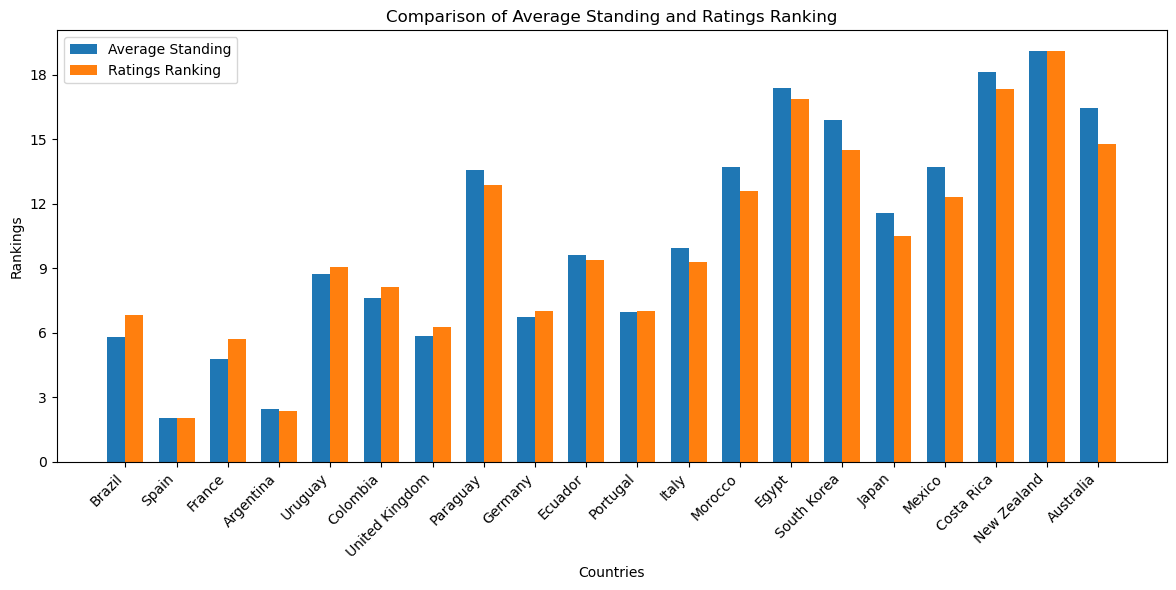

Total games played: 190.0
Total time: 3783.631853494826 hours
{'Brazil': 19.0, 'Spain': 19.0, 'France': 19.0, 'Argentina': 19.0, 'Uruguay': 19.0, 'Colombia': 19.0, 'United Kingdom': 19.0, 'Paraguay': 19.0, 'Germany': 19.0, 'Ecuador': 19.0, 'Portugal': 19.0, 'Italy': 19.0, 'Morocco': 19.0, 'Egypt': 19.0, 'South Korea': 19.0, 'Japan': 19.0, 'Mexico': 19.0, 'Costa Rica': 19.0, 'New Zealand': 19.0, 'Australia': 19.0}
Average Loss: 14.106286783803174


In [50]:
# ---------------------------- PLOTTING ---------------------------------
# Calculate rankings based on countriesratings
ratings_ranking = {country: rank for rank, country in enumerate(sorted(countriesratings, key=countriesratings.get, reverse=True), start=1)}


# Prepare data for the bar graph
avg_standings_values = [avgstandings[country] for country in countries]

# Perform max-min normalization for ratings
min_avg_standing = min(avg_standings_values)
max_avg_standing = max(avg_standings_values)

normalized_ratings = {
    country: max_avg_standing - ((max_avg_standing - min_avg_standing) * (countriesratings[country] - min(countriesratings.values())) / 
                                 (max(countriesratings.values()) - min(countriesratings.values())))
    for country in countries
}

ratings_ranking_values = [normalized_ratings[country] for country in countries]



x = np.arange(len(countries))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, avg_standings_values, width, label='Average Standing')
rects2 = ax.bar(x + width/2, ratings_ranking_values, width, label='Ratings Ranking')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Countries')
ax.set_ylabel('Rankings')
ax.set_title('Comparison of Average Standing and Ratings Ranking')
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.legend()
fig.tight_layout()

ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {2 * (totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
